# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [26]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

fatal: destination path 'ipcv-assignment-2' already exists and is not an empty directory.


In [27]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [28]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

### Import

In [61]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import random_split, DataLoader
from torchvision import transforms as T, datasets
import torchvision.transforms.v2 as v2

from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

print("Using torch", torch.__version__)

Using torch 2.8.0+cu126


### Fix randomness

In [30]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(33)

### GPU check

In [31]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Is the GPU available? True
Device: cuda


### Data preparation

In [32]:
# ========================== Images have different shapes ==========================
train_transformer = T.Compose([

    # RANDOM CROP RESIZE to have uniform size, because the dataset has images of non-uniform dimensions
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),

    # TRIVIAL AUGMENTATION: data augmentation with orizonatl flip
    T.RandomHorizontalFlip(),

    T.ToTensor(), #we get a 3-dimension tensor: img_h x img_w x channels
    #the Loader will then add a dimension: the batch size

    # RANDOM ERASING
    T.ConvertImageDtype(torch.float),



    T.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False), #default values

])

test_transformer = T.Compose([
    T.Resize(256), # mantain the ratio of the image
    T.CenterCrop(224), # crop the right
    T.ToTensor(),
])
# ========================== How do we deal with this !?! ==========================

train_dset = OxfordPetDataset(
    split="train",
    transform=train_transformer,
)
test_dset = OxfordPetDataset(
    split="test",
    transform=test_transformer,
)

n_classes = train_dset.get_num_classes()
print(f"Number of classes: {n_classes}")

input_dim = len(train_dset[0][0])
print(f"Input dimension: {input_dim}")

train_subdset = train_dset

test_dset, val_subdset = random_split(
    test_dset,
    [len(test_dset) - 500, 500]
)

print(f"Number of training samples: {len(train_subdset)}")
print(f"Number of validation samples: {len(val_subdset)}")
print(f"Number of test samples: {len(test_dset)}")

Number of classes: 37
Input dimension: 3
Number of training samples: 3669
Number of validation samples: 500
Number of test samples: 1346


### Data Visualization

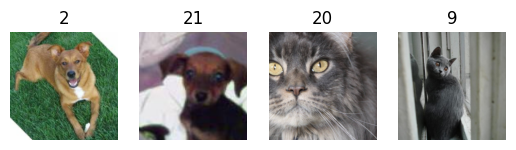

In [33]:
_, ax = plt.subplots(1, 4)

for i, idx in enumerate([0, 10, 20, 30]):
    img, label = test_dset[idx]
    ax[i].imshow(img.reshape(3, 224, 224).permute(1, 2, 0))
    ax[i].set_title(label)
    ax[i].axis("off")

### Data Loader

In [34]:
batch_size = 128

train_dl = DataLoader(
    train_subdset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_subdset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dset,
    batch_size=batch_size
)

### CNN Architecture

In [42]:
# --------------------------------------------------
# Building Blocks
# --------------------------------------------------
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = torch.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = torch.relu(out)
        return out


# --------------------------------------------------
# Generic ResNet
# --------------------------------------------------
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=37, input_channels=3, dropout=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial stem
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Adaptive pooling for variable input size
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


# --------------------------------------------------
# Factory functions for standard ResNets
# --------------------------------------------------
def resnet18(num_classes, input_channels=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, input_channels, dropout=0.5)


def resnet34(num_classes, input_channels=3):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes, input_channels, dropout=0.5)


def resnet50(num_classes, input_channels=3):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, input_channels, dropout=0.5)


def resnet101(num_classes, input_channels=3):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes, input_channels, dropout=0.5)


def resnet152(num_classes, input_channels=3):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes, input_channels, dropout=0.5)


In [43]:
# class ResNet50(nn.Module):
#     """
#     ResNet-50 with adaptive pooling to handle variable input sizes
#     """

#     def __init__(self, num_classes=1000, input_channels=3):
#         super(ResNet50, self).__init__()
#         self.in_channels = 64

#         # Initial layers (same as before)
#         self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         # Residual layers
#         self.layer1 = self._make_layer(Bottleneck, 64, 3, stride=1)
#         self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
#         self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
#         self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

#         # Adaptive pooling handles variable sizes
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * 4, num_classes)  # 4 is Bottleneck.expansion

#     def _make_layer(self, block, out_channels, blocks, stride=1):
#         # Same implementation as before
#         downsample = None
#         if stride != 1 or self.in_channels != out_channels * 4:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels * 4)
#             )

#         layers = []
#         layers.append(block(self.in_channels, out_channels, stride, downsample))
#         self.in_channels = out_channels * 4

#         for _ in range(1, blocks):
#             layers.append(block(self.in_channels, out_channels))

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         # Works with any input size >= 32x32
#         x = torch.relu(self.bn1(self.conv1(x)))
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         # Adaptive pooling ensures output is always 1x1
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)

#         return x

# # Import required for Bottleneck
# class Bottleneck(nn.Module):
#     expansion = 4

#     def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#         super(Bottleneck, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
#         self.downsample = downsample

#     def forward(self, x):
#         identity = x
#         out = torch.relu(self.bn1(self.conv1(x)))
#         out = torch.relu(self.bn2(self.conv2(out)))
#         out = self.bn3(self.conv3(out))

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = torch.relu(out)
#         return out

### Create model

In [44]:
model = resnet18(num_classes=n_classes)
model = model.to(device)

### Optimizer

In [45]:
optimizer = Adam(model.parameters(), decoupled_weight_decay=True)

### Accuracy and Training loop

In [64]:
batch_transforms = v2.Compose([
    v2.MixUp(alpha=1.0, num_classes=n_classes),
    v2.CutMix(alpha=1.0, num_classes=n_classes),
])

def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    if y.ndim == 2:  # soft labels from MixUp/CutMix
        y = torch.argmax(y, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model,
               train_dl,
               epochs,
               opt,
               scheduler=None,
               scheduler_batchwise=False,
               best_model_file_path="best_model.pth",
               val_dl=None,
               verbose=False):

    best_val_acc = 0
    best_params = []
    best_epoch = -1

    for e in tqdm(range(epochs)):
        # ----------[ Training loop ]---------- #
        model.train()
        train_loss = 0
        train_samples = 0
        train_acc = 0

        for train_data in train_dl:
            imgs, labels = train_data[0].to(device), train_data[1].to(device)
            imgs, labels = batch_transforms(imgs, labels)

            scores = model(imgs)
            loss = F.cross_entropy(scores, labels, label_smoothing=0.1)

            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()
            loss.backward()
            opt.step()

            # Step batch-wise scheduler (e.g. OneCycleLR)
            if scheduler is not None and scheduler_batchwise:
                scheduler.step()

        train_acc /= train_samples
        train_loss /= train_samples

        # ----------[ Validation loop ]---------- #
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0

            if val_dl is not None:
                for val_data in val_dl:
                    imgs, labels = val_data[0].to(device), val_data[1].to(device)
                    val_scores = model(imgs)

                    val_loss += F.cross_entropy(val_scores, labels, label_smoothing=0.1).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples

                # Step epoch-wise scheduler
                if scheduler is not None and not scheduler_batchwise:
                    scheduler.step(val_acc)

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, best_model_file_path)
                best_epoch = e

        if verbose:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" +
                  ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc}")

    return best_val_acc, best_params, best_epoch


### Free memory

In [47]:
import gc

torch.cuda.empty_cache()
gc.collect()

1476

### Train the network

In [67]:
epochs = 10

# Scheduler

schedulers={
    'ReduceLROnPlateau': {
        'scheduler': ReduceLROnPlateau(
            optimizer,
            mode="max",
            patience=3
            )
        ,
        'scheduler_batchwise':False
    },
    'OneCycleLR': {
        'scheduler': OneCycleLR(
            optimizer,
            max_lr=1e-3,                      # peak LR
            steps_per_epoch=len(train_dl),    # number of batches per epoch
            epochs=epochs,                    # total number of epochs
            pct_start=0.3,                    # % of cycle to increase LR (default 30%)
            anneal_strategy='cos'             # cosine annealing down
            )
        ,
        'scheduler_batchwise':True
    }
}


# =========== UNCOMMENT if want to improve an already existing model ===========
#model = resnet18(
#    num_classes=n_classes
#)
#model.load_state_dict(torch.load("best_model_luca.pth"))
#model = model.to(device)
# ==============================================================================

# Training
best_val_acc, best_params, best_epoch = train_loop(
    model = model,
    train_dl = train_dl,
    epochs = epochs,
    opt = optimizer,
    scheduler = schedulers['ReduceLROnPlateau']['scheduler'],
    scheduler_batchwise = schedulers['ReduceLROnPlateau']['scheduler_batchwise'],
    best_model_file_path="best_model_luca2.pth",
    val_dl=val_dl,
    verbose=True
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: train loss 2.748 - train acc 0.469 - valid loss 1.984 - valid acc 0.574
Epoch 1: train loss 2.734 - train acc 0.483 - valid loss 1.979 - valid acc 0.580
Epoch 2: train loss 2.801 - train acc 0.442 - valid loss 1.982 - valid acc 0.582
Epoch 3: train loss 2.808 - train acc 0.436 - valid loss 1.956 - valid acc 0.584
Epoch 4: train loss 2.771 - train acc 0.461 - valid loss 1.969 - valid acc 0.586
Epoch 5: train loss 2.799 - train acc 0.460 - valid loss 2.018 - valid acc 0.576
Epoch 6: train loss 2.755 - train acc 0.477 - valid loss 1.965 - valid acc 0.584
Epoch 7: train loss 2.735 - train acc 0.500 - valid loss 2.015 - valid acc 0.572
Epoch 8: train loss 2.725 - train acc 0.469 - valid loss 1.976 - valid acc 0.584
Epoch 9: train loss 2.760 - train acc 0.464 - valid loss 1.986 - valid acc 0.580
Best epoch 4, best acc 0.586


### Load the model

In [68]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("best_model_luca2.pth")

# Create a new model and load the state dict
new_model = model = resnet18(
    num_classes=n_classes
)

# Load the model and send the model wheight to the device
new_model.load_state_dict(state_dict)
new_model = new_model.to(device)

### Evaluation of the model

In [69]:
# Evaluate the model using the test set
new_model.eval()
confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int)

with torch.no_grad():
    for test_data in test_dl:
        imgs, labels = test_data
        imgs = imgs.to(device)
        labels = labels.to(device)

        scores = new_model(imgs)
        preds = torch.argmax(scores, -1)
        ''' scores is a tensor of shape [batch_size, n_classes].
            torch.argmax(scores, -1) returns the index of the maximum score along the last dimension (class dimension).
            So preds is a tensor of shape [batch_size], containing the predicted class index for each sample in the batch. '''

        for lbl, pred in zip(labels.view(-1), preds.view(-1)): #iterate over both labels and predictions
                confusion_matrix[lbl.int(), pred.int()] += 1   #e.g. If the true label is 2 and the model predicted 0, it adds 1 to confusion_matrix[2, 0].

test_acc = (torch.diagonal(confusion_matrix).sum() / confusion_matrix.sum()).item()
print(test_acc)

0.5430906414985657


## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.